In [2]:
!nvidia-smi

Sun Jul  9 10:38:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   34C    P0              56W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import numpy as np
import pandas as pd
import os

import glob
import zipfile
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, CenterCrop

torch.manual_seed(42)

In [4]:
input_dir = "./../carvana/"

In [5]:
train_val_images_path = os.path.join(input_dir, 'train')

train_val_images = os.listdir(train_val_images_path)

train_val_images = sorted(train_val_images)

train_val_images = [s.split("/")[-1].split(".")[0] for s in train_val_images]

len(train_val_images)

5088

In [6]:
train_images, val_images = train_test_split(train_val_images, test_size=0.2)

In [7]:
train_images[0], val_images[0]

('b38c4e132183_08', '3d7a1030deeb_02')

In [8]:
len(train_images), len(val_images)

(4070, 1018)

In [9]:
img_size = 576

class CustomImageDataset(Dataset):
    def __init__(self, img_ids, transform=None):
        self.img_ids = img_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        img_path = os.path.join(input_dir, "train/" + img_id + ".jpg")
        mask_path = os.path.join(input_dir, "train_masks/" + img_id + "_mask.gif")
        
        image = Image.open(img_path)
        image = image.resize((img_size, img_size))
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((img_size, img_size))
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [10]:
training_data = CustomImageDataset(train_images, ToTensor())
val_data = CustomImageDataset(val_images, ToTensor())

In [13]:
sample_x, sample_y = training_data[0]

print(f'Sample X Shape: {sample_x.shape}')
print(f'Sample y Shape: {sample_y.shape}')

Sample X Shape: torch.Size([3, 576, 576])
Sample y Shape: torch.Size([1, 576, 576])


In [14]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=True)

In [15]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [16]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x: torch.Tensor):
        return self.block(x)
    
class CopyAndCrop(nn.Module):
    def forward(self, x: torch.Tensor, encoded: torch.Tensor):
        _, _, h, w = encoded.shape
        crop = CenterCrop((h, w))(x)
        output = torch.cat((x, crop), 1)
        
        return output

    
class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(UNet, self).__init__()

        self.encoders = nn.ModuleList([
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
        ])
        self.down_sample = nn.MaxPool2d(2)
        self.copyAndCrop = CopyAndCrop()
        self.decoders = nn.ModuleList([
            ConvBlock(1024, 512),
            ConvBlock(512, 256),
            ConvBlock(256, 128),
            ConvBlock(128, 64),
        ])


        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])


        self.bottleneck = ConvBlock(512, 1024)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1, stride=1)
        
    def forward(self, x: torch.Tensor):
        # encode
        encoded_features = []
        for enc in self.encoders:
            x = enc(x)
            encoded_features.append(x)
            x = self.down_sample(x)
            
        
        x = self.bottleneck(x)
        
        # decode
        for idx, denc in enumerate(self.decoders):
            x = self.up_samples[idx](x)
            encoded = encoded_features.pop()
            x = self.copyAndCrop(x, encoded)
            x = denc(x)
            
        output = self.final_conv(x)
        return output

In [17]:
model = UNet(in_channels=3, out_channels=1).to(device)
print(model)

UNet(
  (encoders): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      

In [18]:
# class UNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
#         self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
#         self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
#         self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
#         self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
#         self.conv10 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1)
        
#         self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        
#         self.conv11 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
#         self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
#         self.upconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        
#         self.conv13 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
#         self.conv14 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
#         self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        
#         self.conv15 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
#         self.conv16 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
#         self.upconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        
#         self.conv17 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
#         self.conv18 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
#         self.finalconv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
        
#         crop1 = CenterCrop((img_size, img_size))(x)
        
#         x = F.relu(self.pool(x))
        
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))

#         crop2 = CenterCrop((img_size//2, img_size//2))(x)
        
#         x = F.relu(self.pool(x))
        
#         x = F.relu(self.conv5(x))
#         x = F.relu(self.conv6(x))
        
#         crop3 = CenterCrop((img_size//4, img_size//4))(x)
                
#         x = F.relu(self.pool(x))
        
#         x = F.relu(self.conv7(x))
#         x = F.relu(self.conv8(x))
#         crop4 = CenterCrop((img_size//8, img_size//8))(x)
        
#         x = F.relu(self.pool(x))
        
#         x = F.relu(self.conv9(x))
#         x = F.relu(self.conv10(x))
        
#         x = F.relu(torch.cat((self.upconv1(x), crop4), 1))
        
        
#         x = F.relu(self.conv11(x))
#         x = F.relu(self.conv12(x))
        
#         x = F.relu(torch.cat((self.upconv2(x), crop3), 1))

#         x = F.relu(self.conv13(x))
#         x = F.relu(self.conv14(x))
        
#         x = F.relu(torch.cat((self.upconv3(x), crop2), 1))

#         x = F.relu(self.conv15(x))
#         x = F.relu(self.conv16(x))

#         x = F.relu(torch.cat((self.upconv4(x), crop1), 1))

#         x = F.relu(self.conv17(x))
#         x = F.relu(self.conv18(x))

#         x = self.finalconv(x)

#         return x

        
# model = UNet().to(device)
# print(model)

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    train_losses = []
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        
        train_losses.append(loss.item())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_losses

In [21]:
epochs = 3

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history = train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.674082  [   16/ 4070]
loss: 0.132693  [ 1616/ 4070]
loss: 0.087667  [ 3216/ 4070]
Epoch 2
-------------------------------
loss: 0.077820  [   16/ 4070]
loss: 0.052925  [ 1616/ 4070]
loss: 0.046938  [ 3216/ 4070]
Epoch 3
-------------------------------
loss: 0.037962  [   16/ 4070]
loss: 0.030184  [ 1616/ 4070]
loss: 0.024174  [ 3216/ 4070]
Done!


In [34]:
def plot_images(images, mask = False):
    fig = plt.figure(figsize=(10, 8))
    columns = len(images)
    rows = 1
    for i in range(columns * rows):
        img = images[i]
        fig.add_subplot(rows, columns, i + 1)
        if mask:
            img = img > 0.5
        plt.imshow(img, cmap="gray")
    plt.show()

In [35]:
def visualize_result(dataloader):
    tr_imgs = []
    msk_imgs = []
    
    for x, y in dataloader:
        x = x.to(device)
        
        pred = model(x)
        
        for i in range(x.shape[0]):
            tr_img = x[i].cpu().detach().numpy()
            tr_img = np.einsum('kij->ijk',tr_img)
            tr_imgs.append(tr_img)
            
            msk_img = pred[i].cpu().detach().numpy()
            msk_img = msk_img.reshape((img_size, img_size))
            msk_imgs.append(msk_img)

        break
        
    plot_images(tr_imgs, mask=False)
    plot_images(msk_imgs, mask=True)

In [39]:
def plot_history(losses):
    plt.style.use('ggplot')
    plt.plot(losses)
    plt.title('Train loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [40]:
visualize_result(val_dataloader)

OutOfMemoryError: CUDA out of memory. Tried to allocate 162.00 MiB (GPU 0; 39.39 GiB total capacity; 37.37 GiB already allocated; 144.69 MiB free; 37.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

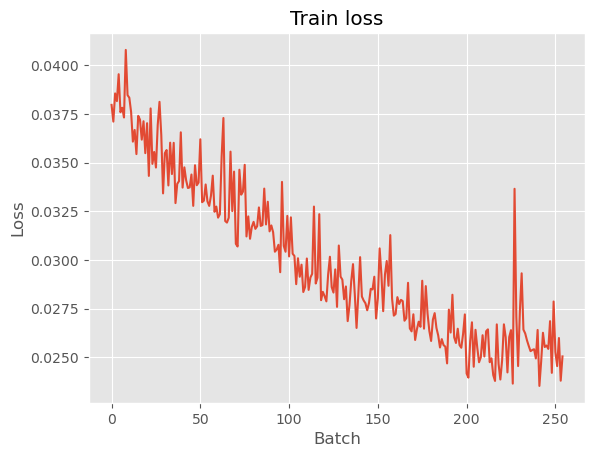

In [41]:
plot_history(history)

In [42]:
torch.save(model.state_dict(), "model.pth")